# MCMC sampling for the FHN model

In [1]:
# Install dependencies
!pip install emcee corner --quiet

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate
from scipy.stats import uniform, gaussian_kde

In [2]:
# ODE model 
def fhn_dynamics(t, x, theta):
    theta = 10**theta
    return np.array([theta[2]*(x[0]-1/3*x[0]**3+x[1]), -1/theta[2]*(x[0]-theta[0]+theta[1]*x[1])])

x0 = [-1, 1]
n_obs = 21 
t_end = 15
time_points = np.linspace(0, t_end, n_obs)
sigma = 0.05   # noise standard deviation

## MCMC samples from the true posterior

Problem: Given an observed data set, generate MCMC samples from the posterior distribution.

Reason: This is needed to validate the posterior samples obtained with BayesFlow.

Generate representative samples from each posterior via MCMC. This is time-intensive. If this has been run already once and results have been stored, one can directly proceed by loading them in the "Load results" section.

## Load test data

In [3]:
param_priors = np.array([[-0.8, -1.4, -1.3], [-1.0, -0.6, -0.1], [-1.7, -1.2, -1.6], [-1.3, -1.4, -0.9], [-0.3, -1.9, -0.8]])
x_augment01 = np.load("x_datas.npy")
x_datas = x_augment01
n_datas = len(x_augment01)

In [4]:
%%time

mcmc_samples = []

for i in range(n_datas):
    present_indices = np.where(x_augment01[i,:,1]==1)[0]
    present_data = x_augment01[i, present_indices, 0]
    
    def log_prior(a,b,g):   
        # Evaluates log-prior probability according to a,b,g ~ U(-2, 0) iid.
        return uniform.logpdf(a,loc=-2,scale=2) + uniform.logpdf(b,loc=-2,scale=2) + uniform.logpdf(g,loc=-2,scale=2)

    def log_likelihood(a,b,g):   
        # Calculates log-likelihood of the available data
        rhs = lambda x,t: fhn_dynamics(t, x, np.array([a,b,g]))
        sol = integrate.odeint(rhs, x0, time_points)
        residual = (present_data - sol[present_indices,0])/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return - nllh

    def log_posterior(a,b,g):   
        # Evaluates the unnormalized log-posterior probability conditioned on the available data
        return log_likelihood(a,b,g) + log_prior(a,b,g)

    def log_posterior_v(x: np.ndarray):
        """Log-posterior with a single vector-valued argument."""
        a,b,g = x
        return log_posterior(a,b,g)

    def sample(n_sample=10000, n_walker=10):
        """Perform sampling using emcee."""
        n_dim = 3
        p0 = np.ones((n_walker,1)) @ np.array([param_priors[i]]) + np.random.normal(0,0.01,(n_walker,n_dim))
        sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
        sampler.run_mcmc(p0, n_sample)    
        samples = sampler.get_chain(flat=True)
        return samples

    # Sample
    samples = sample()
    
    # Posterior sample
    mcmc_samples.append(samples)

CPU times: total: 40min 46s
Wall time: 40min 56s


## Save results

In [5]:
np.save("mcmc_samples.npy", mcmc_samples)

## Load results

In [4]:
mcmc_samples = np.load("mcmc_samples.npy")

In [6]:
def plot_posterior(param_samples, param_names=["a", "b", "g"], cmap="viridis"):
    count = 1
    for i in range(0, param_samples.shape[1]):
        for j in range(0, param_samples.shape[1]):
            plt.subplot(param_samples.shape[1], param_samples.shape[1], count)
            if i != j:
                # Kernel density estimator of MCMC samples
                a = param_samples[:, i]
                b = param_samples[:, j]
                ab = np.vstack([a, b])
                z = gaussian_kde(ab)(ab)
                ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
                a, b, z = a[ida], b[ida], z[ida]
                plt.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)
                plt.xlabel('Parameter ${}$'.format(param_names[i]))
                plt.ylabel('Parameter ${}$'.format(param_names[j]))
            else:
                plt.hist(param_samples[:,i], bins='auto', density=1, color='orange', label='BayesFlow (marginal)')
                plt.ylabel('Marginal density')
                plt.xlabel('Parameter ${}$'.format(param_names[i])) 
            if i == 1 and j == 2:                    
                legend_elements = [
                    Line2D([0], [0], color="orange", markerfacecolor="orange", marker="s", lw=0, markersize=6, label="BayesFlow (marginal)"),
                    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow (2D joint)"),
                ]
                plt.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1,0.5))                    
            count += 1

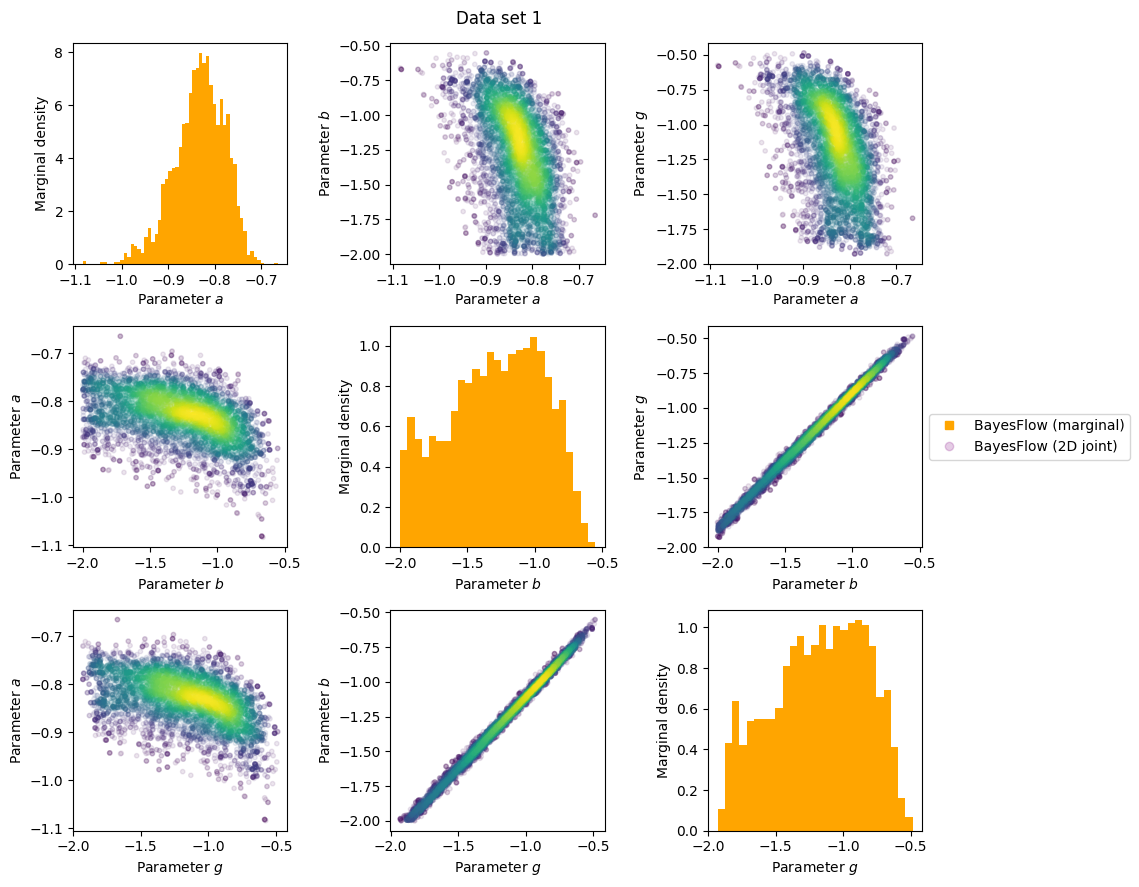

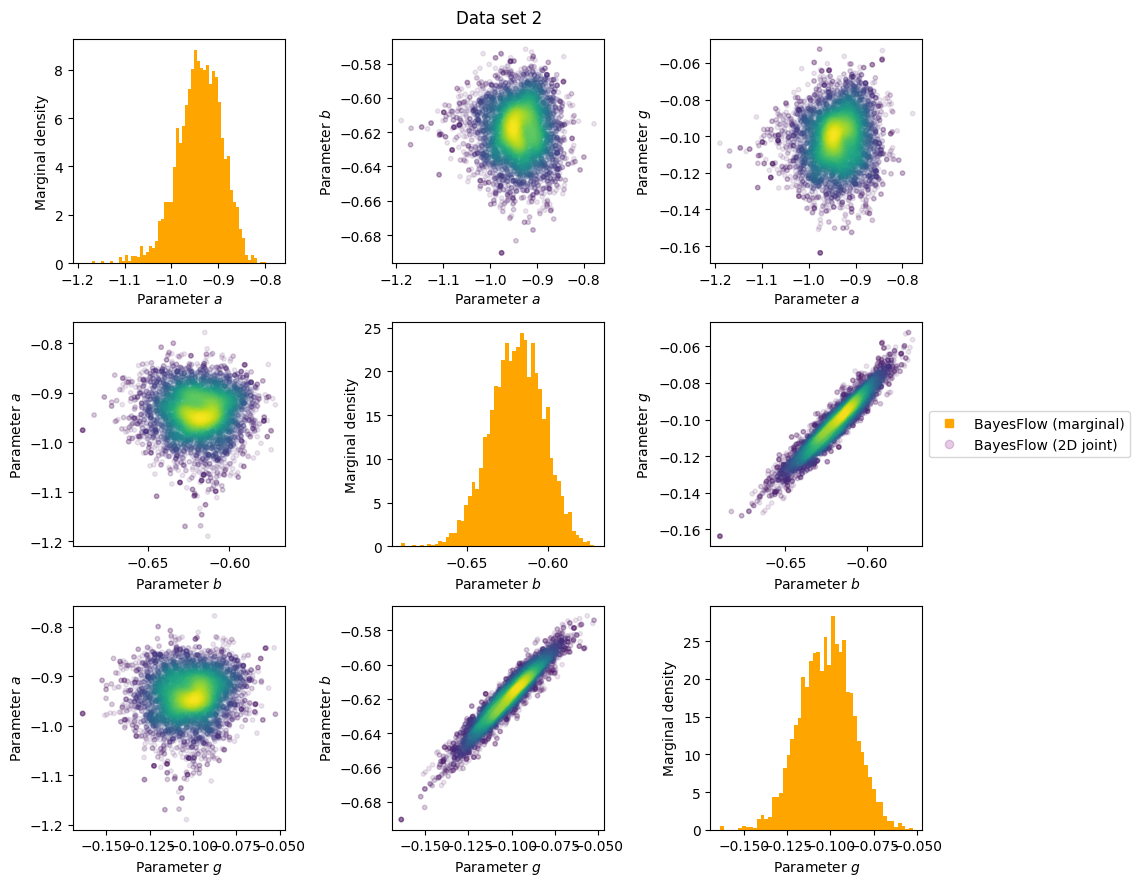

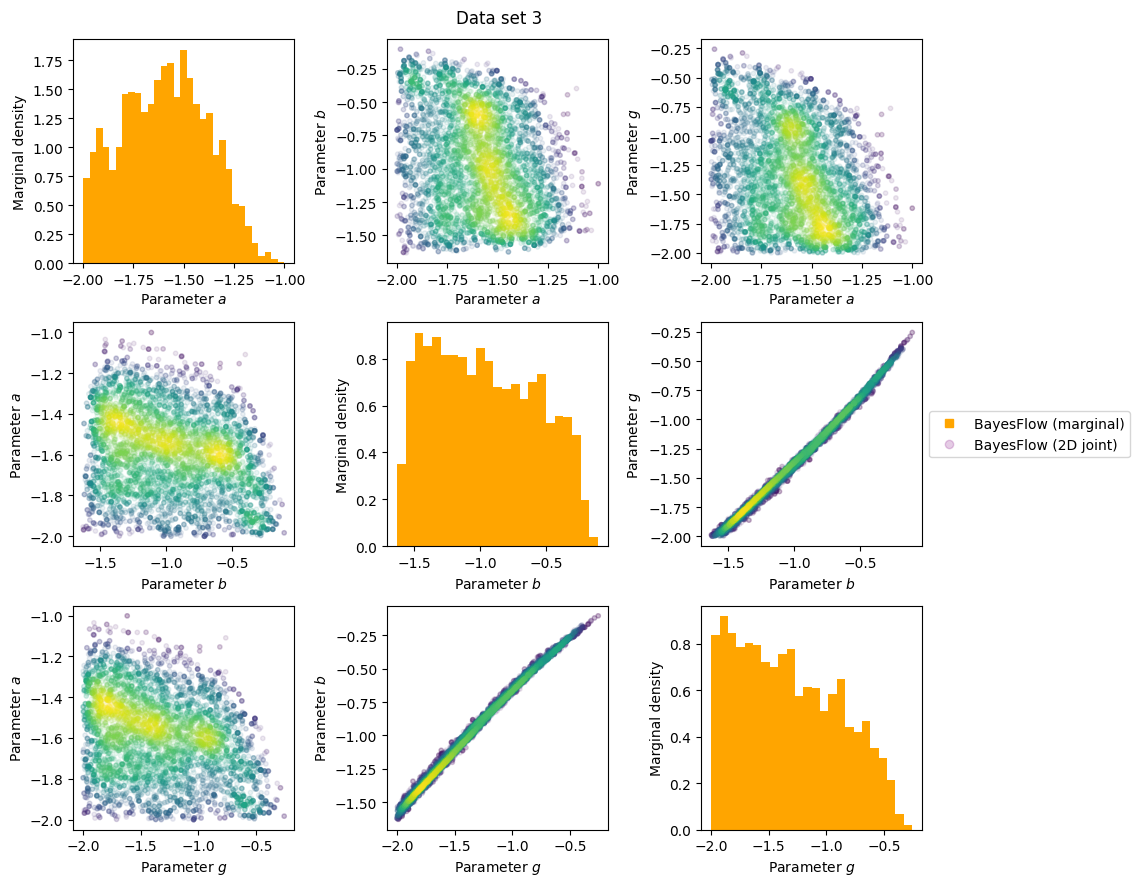

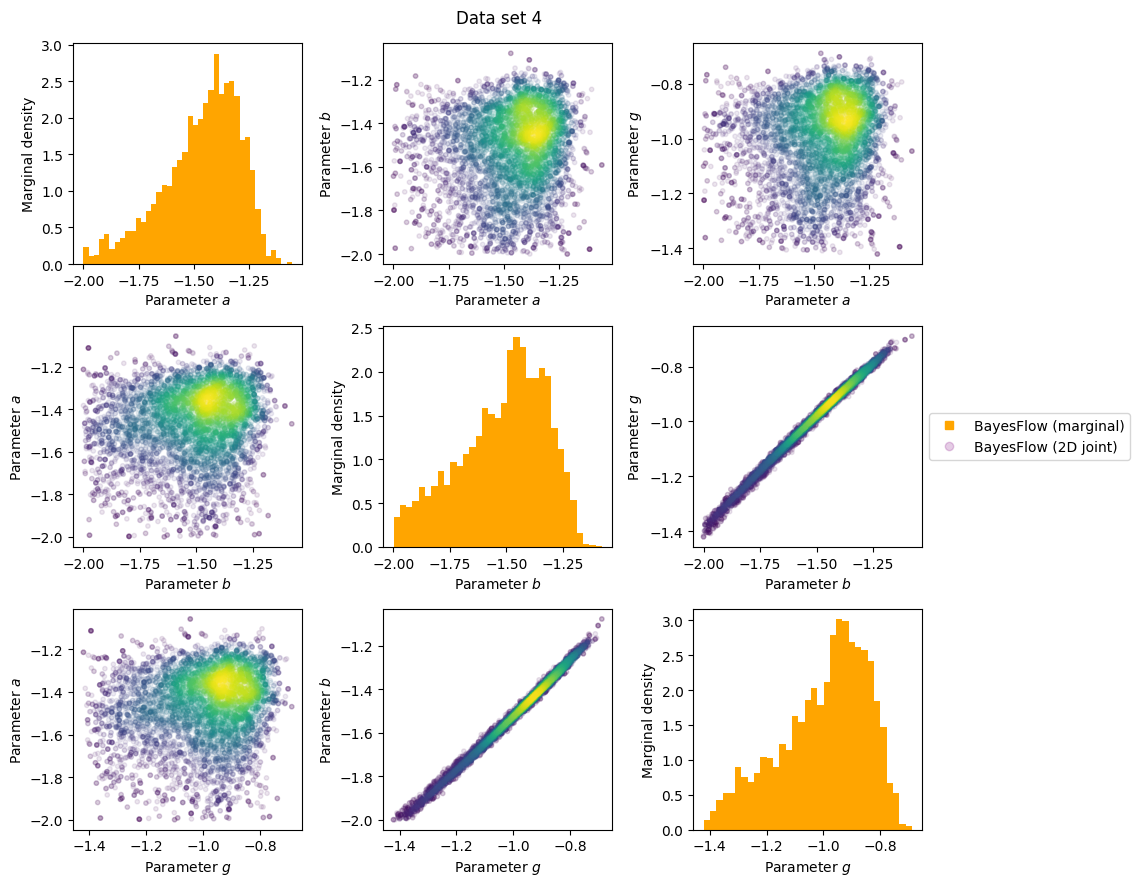

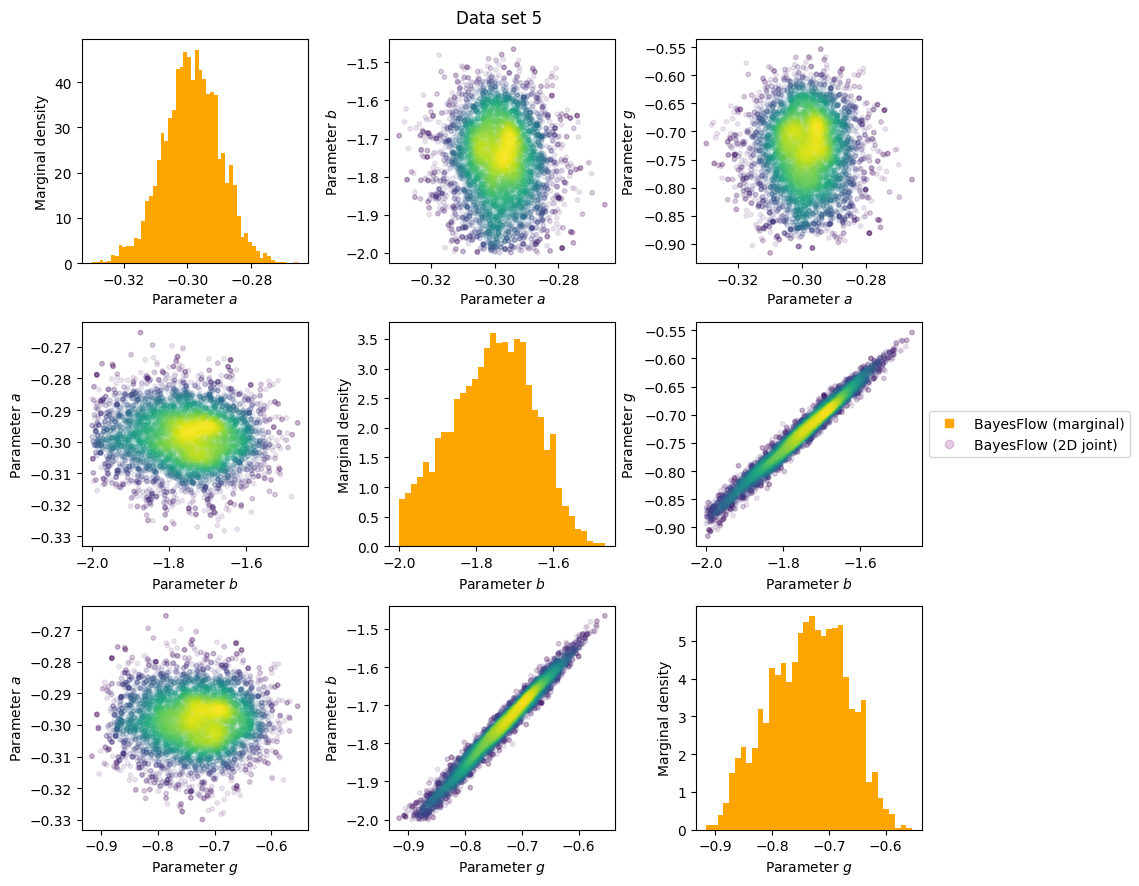

In [7]:
for k in range(len(x_datas)):
    fig = plt.subplots(3, 3, figsize=(11.5, 9))
    plot_posterior(mcmc_samples[k][2500:10000])
    plt.suptitle("Data set {}                           ".format(k+1))
    plt.tight_layout()
    plt.savefig("figures/FHN_MCMC_{}.png".format(k+1), dpi=300, bbox_inches='tight')
    plt.savefig("figures/FHN_MCMC_{}.pdf".format(k+1), bbox_inches='tight')

In [8]:
def plot_predictive_check(ax, param_prior, x_data, param_samples, n_sim=1000):
    
    time_avail = time_points[x_data[:,1]==1]
    x_avail = x_data[x_data[:,1]==1, 0]
    
    grid = 151
    time_line = np.linspace(0, t_end, grid) 
    traj_sim = np.empty((n_sim, grid))

    for k in range(n_sim):
        rhs = lambda x,t: fhn_dynamics(t, x, param_samples[k+8000])
        sol = integrate.odeint(rhs, x0, time_line)  
        traj_sim[k] = sol[:,0] + np.random.normal(0, sigma, size=grid)
        
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    
    ax.plot(time_line, traj_mean, color='tab:orange', label='Simulated mean $V$')
    ax.fill_between(time_line, traj_quantiles[0], traj_quantiles[1], color='tab:orange', alpha=.25)
    
    rhs = lambda x,t: fhn_dynamics(t, x, param_prior)
    sol = integrate.odeint(rhs, x0, time_line)
    ax.plot(time_line, sol[:,0], color='black', linestyle='dashed', label='True trajectory') 
    ax.plot(time_avail, x_avail, 'o', color='tab:blue', markersize=4.5, label='Available data $V$')
        
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

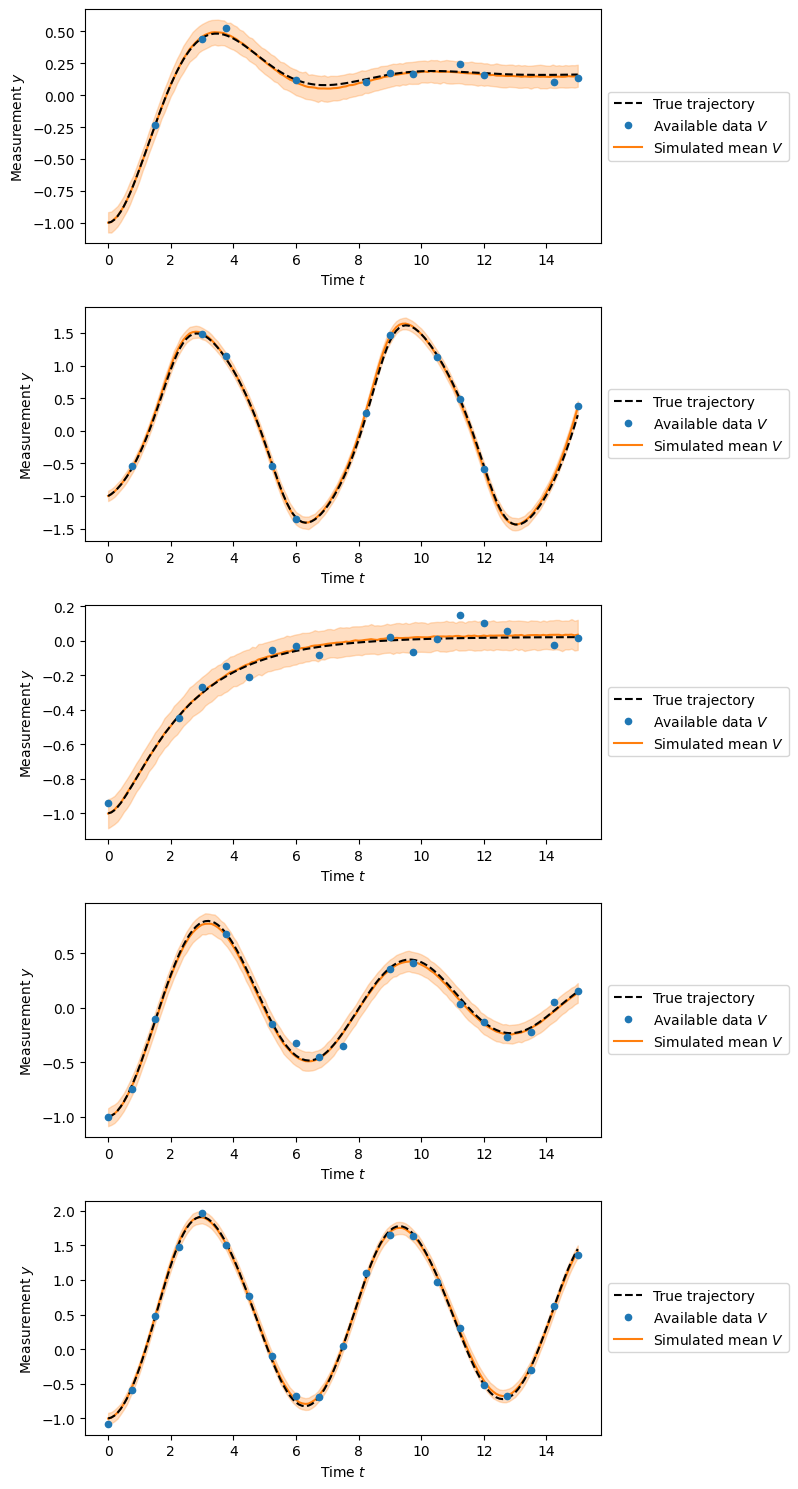

In [9]:
fig, axes = plt.subplots(5, figsize=(8, 15))

for j in range(len(x_datas)): 
    ax = axes[j]
    plot_predictive_check(ax, param_priors[j], x_datas[j], mcmc_samples[j])  
    handles, labels = ax.get_legend_handles_labels()
    order = [1,2,0]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/FHN_mcmc_predictive.{fmt}", dpi=300, bbox_inches='tight')